## LSTM using Tensorflow

In [1]:
# Import Dependencies
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

c:\users\hare krishna\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Create a Class for Generating Data and sending it in Batches
class TimeSeriesData():
    # Initialize all Variables and get Sample Values for Sine wave
    def __init__(self, num_points, xmin, xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        # Get resolution of data
        self.resolution = (xmax-xmin)/num_points
        # Generate Features i.e. data points
        self.X = np.linspace(xmin, xmax, num_points)
        # Generate Labels i.e. sine wave using data points
        self.y = np.sin(self.X)
        
    # Takes in any series of x values and returns true sine value for x_series
    def ret_true(self, x_series):
        return np.sin(x_series)
    
    # Generate Batches of Data
    def next_batch(self, batch_size, steps, return_batch_ts=False):
        # Grab a random starting point for each point of data
        # Generate some random values
        rand_start = np.random.rand(batch_size,1)
        
        # Convert it to be on Time Series
        # Since the generated random values might not lie on the actual time series, so preprocess it to lie on the time series graph.
        ts_start = rand_start * (self.xmax - self.xmin - (steps * self.resolution)) 
        
        # Create batch time series on x axis
        batch_ts = ts_start + np.arange(0.0, steps + 1) * self.resolution
                                 
        # Create the y data for time series x axis from previous step
        y_batch = np.sin(batch_ts)
        
        # Format data for input to a RNN
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1), batch_ts
        else:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1)

In [3]:
# Test out the Functions in Class Above
ts_data = TimeSeriesData(num_points=250, xmin=0, xmax=10)

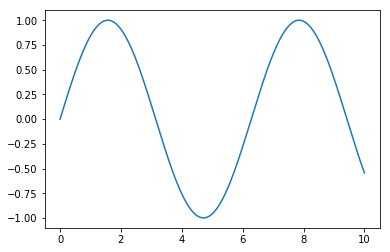

In [4]:
plt.plot(ts_data.X, ts_data.y)

In [5]:
# Each Random batch with 30 steps
num_time_steps = 30

In [6]:
y1, y2, ts = ts_data.next_batch(batch_size=1, steps=num_time_steps, return_batch_ts=True)

In [7]:
ts.shape

(1, 31)

In [8]:
ts.flatten()

array([8.21665634, 8.25665634, 8.29665634, 8.33665634, 8.37665634,
       8.41665634, 8.45665634, 8.49665634, 8.53665634, 8.57665634,
       8.61665634, 8.65665634, 8.69665634, 8.73665634, 8.77665634,
       8.81665634, 8.85665634, 8.89665634, 8.93665634, 8.97665634,
       9.01665634, 9.05665634, 9.09665634, 9.13665634, 9.17665634,
       9.21665634, 9.25665634, 9.29665634, 9.33665634, 9.37665634,
       9.41665634])

In [9]:
ts.flatten().shape

(31,)

In [10]:
ts

array([[8.21665634, 8.25665634, 8.29665634, 8.33665634, 8.37665634,
        8.41665634, 8.45665634, 8.49665634, 8.53665634, 8.57665634,
        8.61665634, 8.65665634, 8.69665634, 8.73665634, 8.77665634,
        8.81665634, 8.85665634, 8.89665634, 8.93665634, 8.97665634,
        9.01665634, 9.05665634, 9.09665634, 9.13665634, 9.17665634,
        9.21665634, 9.25665634, 9.29665634, 9.33665634, 9.37665634,
        9.41665634]])

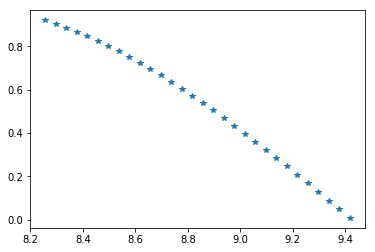

In [11]:
plt.plot(ts.flatten()[1:], y2.flatten(), '*')

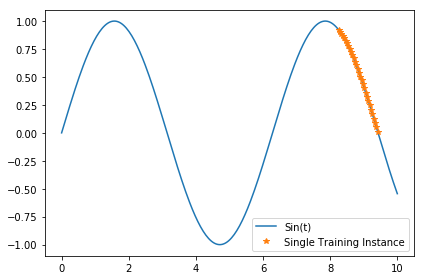

In [12]:
plt.plot(ts_data.X, ts_data.y, label='Sin(t)')
plt.plot(ts.flatten()[1:], y2.flatten(), '*', label='Single Training Instance')
plt.legend()
plt.tight_layout()

### Training Data Visualization

In [13]:
# Create a training Instance i.e. Generate values for training
train_inst = np.linspace(5, 5 + ts_data.resolution * (num_time_steps + 1), num_time_steps + 1)

In [14]:
train_inst

array([5.        , 5.04133333, 5.08266667, 5.124     , 5.16533333,
       5.20666667, 5.248     , 5.28933333, 5.33066667, 5.372     ,
       5.41333333, 5.45466667, 5.496     , 5.53733333, 5.57866667,
       5.62      , 5.66133333, 5.70266667, 5.744     , 5.78533333,
       5.82666667, 5.868     , 5.90933333, 5.95066667, 5.992     ,
       6.03333333, 6.07466667, 6.116     , 6.15733333, 6.19866667,
       6.24      ])

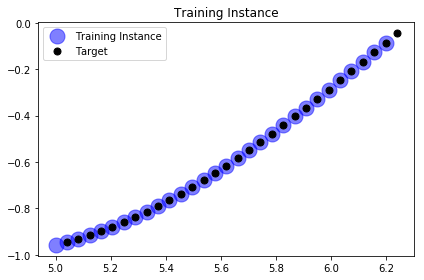

In [15]:
# Plot the Training Data
plt.title('Training Instance')
# Plot Training Data
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), 'bo', markersize=15, alpha=0.5, label='Training Instance')
# Plot Time Shifted Data imitating the point value from Trained Model
plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]), 'ko', markersize=7, label='Target')
plt.legend()
plt.tight_layout()

### Creating the RNN Model

In [16]:
tf.reset_default_graph()

In [17]:
# Define Constants
# Input : X
num_inputs = 1

# Neurons in Hidden Layer
num_neurons = 100

# Number of Outputs Required
num_outputs = 1

# Learning Rate
lr = 0.001

# Number of Training Iterations
num_iters = 2000

# Batch Size
batch_size = 1

In [18]:
# Placeholders
# Features: X
# Shape = [Batch Size, Number of Time Steps i.e. No. of RNN Units, Number of Inputs]
#       = [1, 30, 1] i.e. 30 values as input into 30 RNN units.
X = tf.placeholder(tf.float32, shape=[None, num_time_steps, num_inputs])

# Labels
y = tf.placeholder(tf.float32, shape=[None, num_time_steps, num_outputs])

In [19]:
# Create RNN Cell Layer
# Since, we want only one output and not 100 using 100 neurons in hidden layer, we wrap the rnn model into output wrapper
lstm_model = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu), output_size=num_outputs)

In [20]:
# Get Output of RNN Cell
# Performs dynamic unrolling of RNN cells
outputs, states = tf.nn.dynamic_rnn(lstm_model, X, dtype=tf.float32)

In [21]:
# Loss Function: MSE
loss = tf.reduce_mean(tf.square(outputs-y))

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

In [22]:
init = tf.global_variables_initializer()

In [23]:
# Save Trained Model
save_model = tf.train.Saver()

In [24]:
# Run RNN in Session
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(num_iters):
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        sess.run(optimizer, feed_dict={X: X_batch,y:y_batch})
        
        if i%100 == 0:
            mse = loss.eval(feed_dict={X:X_batch, y:y_batch})
            print('STEP: {0}, ERROR: {1}'.format(i, mse))
    print('STEP: {0}, ERROR: {1}'.format(i, mse))
    save_model.save(sess,'./trained-lstm-model/lstm_time_series_model')

STEP: 0, ERROR: 0.745770275592804
STEP: 100, ERROR: 0.024820635095238686
STEP: 200, ERROR: 0.03606242686510086
STEP: 300, ERROR: 0.023157170042395592
STEP: 400, ERROR: 0.0011903675040230155
STEP: 500, ERROR: 0.0022205461282283068
STEP: 600, ERROR: 0.015271555632352829
STEP: 700, ERROR: 0.00899113155901432
STEP: 800, ERROR: 0.0021449020132422447
STEP: 900, ERROR: 0.0022788504138588905
STEP: 1000, ERROR: 0.0008640565210953355
STEP: 1100, ERROR: 0.0038399912882596254
STEP: 1200, ERROR: 0.002718545962125063
STEP: 1300, ERROR: 0.0013727006735280156
STEP: 1400, ERROR: 0.00045106475590728223
STEP: 1500, ERROR: 4.8174413677770644e-05
STEP: 1600, ERROR: 9.890734509099275e-05
STEP: 1700, ERROR: 0.00040442231693305075
STEP: 1800, ERROR: 0.00011667965009110048
STEP: 1900, ERROR: 0.000272206321824342
STEP: 1999, ERROR: 0.000272206321824342


In [25]:
# Predict Time Series into the Future
with tf.Session() as sess:
    save_model.restore(sess,'./trained-lstm-model/lstm_time_series_model')
    
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X:X_new})

INFO:tensorflow:Restoring parameters from ./trained-lstm-model/lstm_time_series_model


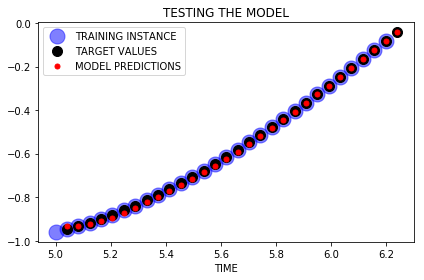

In [26]:
# Plot the Time Predicted Value
plt.title('TESTING THE MODEL')
# Training Data
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), 'bo', markersize=15, alpha=0.5, label='TRAINING INSTANCE')
# Test Data
plt.plot(train_inst[1:], np.sin(train_inst[1:]), 'ko', markersize=10, label='TARGET VALUES')
# Model Predited Values
plt.plot(train_inst[1:], y_pred[0,:,0], 'r.', markersize=10, label='MODEL PREDICTIONS')
plt.xlabel('TIME')
plt.legend()
plt.tight_layout()